# Анализ оттока клиентов банка "Метанпром"

## Цель проекта и заказчик

Заказчиком нашего проекта является банк "Метанпром", а именно его маркетинговый отдел. Главной проблемой для банка является отток клиентов, на привлечение новых у нас нет бюджета и нужно удержать уже дейтсвующих, поэтому перед собой мы ставим следующий задачи:
<br>
* Выделение портретов клиентов, которые склонны уходить из банка
* Поиск зависимостей между оттоком и характеристиками клиентов (поиск возможных причин оттока)
* Построение модели ML, способной предсказать вероятность оттока клиентов в будущем по его фичам
* Проверка статистических гипотез
* Формулировка предложения для отдела маркетинга по уменьшениею оттока клиентов

## Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — приблизительная оценка собственности клиента,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — был ли клиент активен последнее время,
- `salary` — заработная плата клиента
- `churn` — уходит или нет

In [80]:
!pip install catboost
!pip install phik
!pip install shap

In [152]:
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import shap

from scipy.stats import mannwhitneyu
import scipy

## Предобработка
 1. Оценка размеров датесета, названий столбцов, типов данных в столбцах
 2. Поиск пропусков и при необходимости заполнение (средним, медианой, маркером, константой)
 3. Поиск и обработка явных и неявных дубликатов
 4. Поиск и обработка выбросов в данных
 5. Преобразование категориальных переменных one-hot кодированием

In [82]:
# чтение файла с данными и сохранение его в переменную
try:
    df = pd.read_csv('bank_new_dataset.csv')
except FileNotFoundError:
    path = "https://drive.google.com/uc?export=download&id=1avzNMbAm9vCBXJWBpGUK6mZxGHLjcgGl"
    df = pd.read_csv(path)

In [83]:
# удалим доп столбец с индексом
df = df.drop(columns = 'Unnamed: 0', axis = 1)

In [84]:
print('Посмотрим на первые 10 строк')
display(df.head())
print('Посмотрим на разброс величин')
display(df.describe())
print('Посмотрим на типы данных и пропуски')
df.info()

Посмотрим на первые 10 строк


userid  score     city gender  age  equity     balance  products  \
0  258835    673   Ростов      Ж   32       0   467428.54         1   
1   96660    691   Ростов      Ж   31       3    65548.60         1   
2   99838    679   Ростов      Ж   30       1   686979.40         1   
3  216099    717  Рыбинск      Ж   25       2  1292171.92         1   
4  120240    744  Рыбинск      Ж   37       1  1390927.97         1   

   credit_card  last_activity     salary  churn  
0            0              1   81011.65   True  
1            0              1   57005.02   True  
2            1              1  149687.98   True  
3            0              1   19502.68   True  
4            0              1   36861.24   True

Посмотрим на разброс величин


userid         score           age        equity       balance  \
count   10000.000000  10000.000000  10000.000000  10000.000000  7.706000e+03   
mean   153706.098000    603.584900     42.837100      1.747200  7.796362e+05   
std     68883.529645    132.177043     12.128507      1.713764  2.102703e+06   
min      1436.000000    300.000000     18.000000      0.000000  2.197600e+02   
25%     98693.000000    506.000000     34.000000      0.000000  1.886929e+05   
50%    159656.000000    610.000000     40.000000      1.000000  4.265765e+05   
75%    212808.500000    713.000000     51.000000      3.000000  9.655175e+05   
max    264013.000000    850.000000     86.000000      9.000000  1.263859e+08   

           products   credit_card  last_activity        salary  
count  10000.000000  10000.000000   10000.000000  1.000000e+04  
mean       1.115900      0.842300       0.499800  9.546812e+04  
std        0.410712      0.364478       0.500025  1.325737e+05  
min        0.000000      0.000000       0.000000  3.808400e+02  
25%        1.000000      1.000000       0.000000  3.144929e+04  
50%        1.000000      1.000000       0.000000  6.344057e+04  
75%        1.000000      1.000000       1.000000  1.087959e+05  
max        4.000000      1.000000       1.000000  1.378131e+06

Посмотрим на типы данных и пропуски
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7706 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(1), float64(2), int64(7), object(2)
memory usage: 869.3+ KB


In [85]:
# посчитаем доли пропусков
df.isna().mean()

userid           0.0000
score            0.0000
city             0.0000
gender           0.0000
age              0.0000
equity           0.0000
balance          0.2294
products         0.0000
credit_card      0.0000
last_activity    0.0000
salary           0.0000
churn            0.0000
dtype: float64

Обнаруживаем в столбце balance 23% пропусков. Будем считать, что это нулевой баланс и заполним нулями
Так же в столбце products одна строка с 0, это скорее всего ошибка, удалим ее.

In [86]:
df[df['balance'].isna()].describe()

userid        score          age       equity  balance  \
count    2294.000000  2294.000000  2294.000000  2294.000000      0.0   
mean   150769.466434   448.884481    41.833043     0.049695      NaN   
std     69348.597071    88.461030    11.714459     0.217361      NaN   
min      1832.000000   300.000000    18.000000     0.000000      NaN   
25%     93480.500000   376.000000    33.000000     0.000000      NaN   
50%    154915.000000   440.000000    39.000000     0.000000      NaN   
75%    210963.500000   511.000000    49.000000     0.000000      NaN   
max    263946.000000   758.000000    86.000000     1.000000      NaN   

          products  credit_card  last_activity        salary  
count  2294.000000  2294.000000    2294.000000  2.294000e+03  
mean      1.006103     0.996513       0.541848  1.726041e+05  
std       0.077899     0.058964       0.498354  1.950164e+05  
min       1.000000     0.000000       0.000000  8.393250e+03  
25%       1.000000     1.000000       0.000000  7.721866e+04  
50%       1.000000     1.000000       1.000000  1.144434e+05  
75%       1.000000     1.000000       1.000000  1.678477e+05  
max       2.000000     1.000000       1.000000  1.327784e+06

In [87]:
df[df['balance'].isna()]['churn'].value_counts()

False    2294
Name: churn, dtype: int64

Судя по данным, пропуски с балансом имеют пользователи с одним продуктом - кредитной картой, все они не отточные. Возможно это пользователи с заблокированными кредитками или исчерпавшими лимит.

In [88]:
# заполним пропуски 0-ми
df = df.fillna(0)

In [89]:
# удалим не клиентов
df = df[df['products']!=0]

In [90]:
# проверим на дубликаты
if df.duplicated().sum() == 0 : print('Дубликатов не обнаружено')
else : print('Есть явные дубликаты')

Дубликатов не обнаружено


In [91]:
# отдельно проверим user_id на дубликаты
df.duplicated(subset = ['userid']).sum()

0

In [92]:
# проверим на неявные дубликаты
for column in df.columns:
    if df[column].dtype == object:
        print('Значения столбца ', column, ' :')
        print(df[column].unique())
        print('_____________________')
        print()

Значения столбца  city  :
['Ростов' 'Рыбинск' 'Ярославль']
_____________________

Значения столбца  gender  :
['Ж' 'М']
_____________________



In [93]:
df.duplicated(subset = ['userid']).sum()

0

In [94]:
# оценим распределение количественных параметров по столбцам
for column in df.drop(columns = 'userid'):
    if df[column].dtype != object and df[column].nunique()>2:
        fig = px.box(df, y=column)
        fig.show()

Проблемных выбросов не обнаружено (выдающиеся значения есть в возрасте, балансе, зарплате, но мы считаем это нормальным и не искажающим картину исследования)

### Выводы по предобработке:
1. В наших данных 10000 записей, дубликатов не обнаружено
2. В столбце баланс 23% пропуска, их слишком много для полного удаления, мы решили заполнить их значением 0
3. Выбросов негативно влияющих на исследование не обнаружено


## EDA

### Анализ параметра Score

<AxesSubplot:>

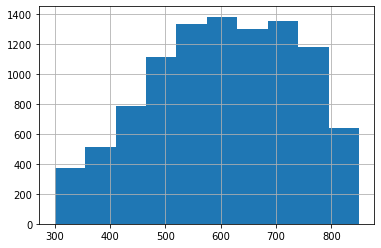

In [95]:
df['score'].hist()

In [96]:
fig = px.histogram(df, x = 'score', color = 'churn', histnorm = 'probability', title = 'Распределение SCORE ')
fig.show()

__Вывод:__ Клиенты имеющие низкий балл кредитного скоринга (до 630) практически не уходят

### Анализ параметра city

In [97]:
fig = px.histogram(df, x = 'city', color = 'churn', histnorm = 'probability', title = 'Распределение по городам ')
fig.show()

__Вывод:__ Зависимость оттока от города практически отсутствует.

### Анализ параметра gender

In [19]:
fig = px.histogram(df, x = 'gender', color = 'churn', histnorm = 'probability', title = 'Распределение по полу ')
fig.show()

__Вывод:__ Зависимость оттока от пола практически отсутствует.

### Анализ параметра age

In [20]:
fig = px.histogram(df, x = 'age', color = 'churn', histnorm = 'probability', title = 'Распределение по возрасту ')
fig.show()

__Вывод:__ Зависимость оттока от возраста не обнаружена

### Анализ параметра equity

In [98]:
fig = px.histogram(df, x = 'equity', color = 'churn', histnorm = 'probability', title = 'Распределение по собственности клиента ')
fig.show()

<AxesSubplot:title={'center':'Отточность от оценки собственности'}, xlabel='equity'>

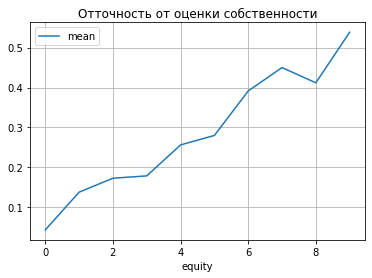

In [159]:
df.groupby('equity')['churn'].agg(['mean']).plot(grid = True, title = 'Отточность от оценки собственности')

__Вывод:__ Клиенты с оценкой собственности "0" наименее сколнны к оттоку.

### Анализ параметра balance

In [99]:
# разобъём баланс на интервалы
df['balance_group'] = pd.qcut(df['balance'], 6 ,duplicates='drop')
df

userid  score       city gender  age  equity     balance  products  \
0     258835    673     Ростов      Ж   32       0   467428.54         1   
1      96660    691     Ростов      Ж   31       3    65548.60         1   
2      99838    679     Ростов      Ж   30       1   686979.40         1   
3     216099    717    Рыбинск      Ж   25       2  1292171.92         1   
4     120240    744    Рыбинск      Ж   37       1  1390927.97         1   
...      ...    ...        ...    ...  ...     ...         ...       ...   
9995  186605    466    Рыбинск      М   42       0        0.00         1   
9996  204842    311  Ярославль      М   27       0        0.00         1   
9997  216640    637  Ярославль      Ж   44       2    48712.99         1   
9998  168786    801    Рыбинск      Ж   38       3   111339.65         1   
9999  128656    458  Ярославль      Ж   37       0        0.00         1   

      credit_card  last_activity     salary  churn               balance_group  
0               0              1   81011.65   True      (268632.54, 546406.96]  
1               0              1   57005.02   True          (-0.001, 97491.49]  
2               1              1  149687.98   True     (546406.96, 1062531.58]  
3               0              1   19502.68   True  (1062531.58, 126385904.82]  
4               0              1   36861.24   True  (1062531.58, 126385904.82]  
...           ...            ...        ...    ...                         ...  
9995            1              1   85203.00  False          (-0.001, 97491.49]  
9996            1              0  141654.61  False          (-0.001, 97491.49]  
9997            1              1   74877.32  False          (-0.001, 97491.49]  
9998            1              0   24478.47  False       (97491.49, 268632.54]  
9999            1              1  171531.19  False          (-0.001, 97491.49]  

[9999 rows x 13 columns]

<AxesSubplot:title={'center':'Зависимость оттока от баланса'}, xlabel='balance_group'>

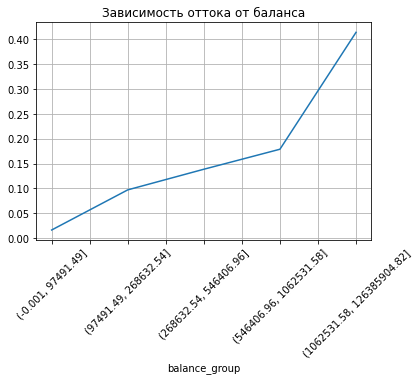

In [160]:
# построим график зависимости оттока от баланса на счету
t = df.groupby('balance_group',dropna=False)['churn'].agg(['mean'])
t['mean'].plot(grid = True, rot = 45, title = 'Зависимость оттока от баланса' )

In [24]:
t

mean
balance_group                       
(-0.001, 97491.49]          0.016502
(97491.49, 268632.54]       0.097181
(268632.54, 546406.96]      0.138655
(546406.96, 1062531.58]     0.178872
(1062531.58, 126385904.82]  0.413917

__Вывод:__ Наблюдаем резкий рост оттока с ростом суммы на счету

### Анализ параметра products

In [101]:
fig = px.histogram(df, x = 'products', color = 'churn', histnorm = 'probability', title = 'Распределение по количеству продуктов ')
fig.show()

In [102]:
df.groupby('products')['churn'].agg(['count','mean']).reset_index()

products  count      mean
0         1   9161  0.122476
1         2    524  0.000000
2         3    306  1.000000
3         4      8  1.000000

In [103]:
df[df['products'] == 3]['churn'].value_counts()

True    306
Name: churn, dtype: int64

__Вывод:__ Основная часть клиентов имеет 1 продукт банка, 2 и 3 намного меньше. <br> 
Среди клиентов имеющих 1 продукт - 12% отточных, 2 продукта 0%, `3 и 4 продукта 100%`

### Анализ параметра credit_card

In [104]:
fig = px.histogram(df, x = 'credit_card', color = 'churn', histnorm = 'probability', title = 'Распределение по наличию кредитной карты ')
fig.show()

In [29]:
df.groupby('credit_card')['churn'].agg(['count','mean']).reset_index()

credit_card  count      mean
0            0   1576  0.420051
1            1   8423  0.091891

<AxesSubplot:>

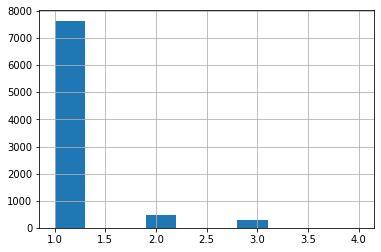

In [30]:
# посмотрим у кого есть только кредитная карта
df[df['credit_card'] == 1]['products'].hist()

In [31]:
# посмотрим на их отток
t = df.query('products ==1 & credit_card == 1')
t['churn'].mean()

0.061470049699189115

__Выводы:__ Большинство наших клиентов имеют кредитную карту, однако, среди тех, кто не имеет - 42% отточных. Те кто имеют `только` кредитную карту - не отточные.

### Анализ параметра last_activity

In [105]:
fig = px.histogram(df, x = 'last_activity', color = 'churn', histnorm = 'probability', title = 'Распределение по активности ')
fig.show()
df.groupby('last_activity')['churn'].agg(['count','mean']).reset_index()

last_activity  count      mean
0              0   5001  0.042791
1              1   4998  0.244498

In [33]:
# рассмотрим активных пользователей
df[df['last_activity'] == 1].describe()

userid        score          age       equity       balance  \
count    4998.000000  4998.000000  4998.000000  4998.000000  4.998000e+03   
mean   153778.286515   591.390956    42.768107     1.749100  6.298869e+05   
std     68411.228489   131.035216    12.580056     1.774306  2.425655e+06   
min      2229.000000   300.000000    18.000000     0.000000  0.000000e+00   
25%     99755.000000   496.000000    33.000000     0.000000  6.613673e+03   
50%    158142.500000   596.000000    40.000000     1.000000  2.606651e+05   
75%    212706.250000   694.000000    52.000000     3.000000  7.788141e+05   
max    263963.000000   850.000000    86.000000     9.000000  1.263859e+08   

          products  credit_card  last_activity        salary  
count  4998.000000  4998.000000         4998.0  4.998000e+03  
mean      1.114446     0.827731            1.0  9.888746e+04  
std       0.436144     0.377652            0.0  1.362131e+05  
min       1.000000     0.000000            1.0  3.808400e+02  
25%       1.000000     1.000000            1.0  3.087649e+04  
50%       1.000000     1.000000            1.0  6.501995e+04  
75%       1.000000     1.000000            1.0  1.127322e+05  
max       4.000000     1.000000            1.0  1.378131e+06

__Вывод:__ Активных и неактивных пользователей по 50%, однако среди активных 24% отточных.Большинство активных пользователей имеют один продукт - кредитную карту.

### Анализ параметра salary

In [106]:
# разобъём баланс на интервалы
df['salary_group'] = pd.qcut(df['salary'], 6 ,duplicates='drop')
df.head()

userid  score     city gender  age  equity     balance  products  \
0  258835    673   Ростов      Ж   32       0   467428.54         1   
1   96660    691   Ростов      Ж   31       3    65548.60         1   
2   99838    679   Ростов      Ж   30       1   686979.40         1   
3  216099    717  Рыбинск      Ж   25       2  1292171.92         1   
4  120240    744  Рыбинск      Ж   37       1  1390927.97         1   

   credit_card  last_activity     salary  churn               balance_group  \
0            0              1   81011.65   True      (268632.54, 546406.96]   
1            0              1   57005.02   True          (-0.001, 97491.49]   
2            1              1  149687.98   True     (546406.96, 1062531.58]   
3            0              1   19502.68   True  (1062531.58, 126385904.82]   
4            0              1   36861.24   True  (1062531.58, 126385904.82]   

               salary_group  
0     (63460.17, 90963.117]  
1      (40610.68, 63460.17]  
2  (132493.663, 1378131.45]  
3       (380.839, 24250.15]  
4      (24250.15, 40610.68]

<AxesSubplot:title={'center':'Зависимость оттока от зарплаты'}, xlabel='salary_group'>

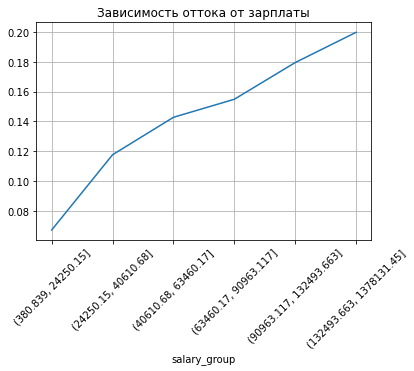

In [161]:
# построим график зависимости оттока от зарплаты
t = df.groupby('salary_group',dropna=False)['churn'].agg(['mean'])
t['mean'].plot(grid = True, rot = 45, title = 'Зависимость оттока от зарплаты')

In [36]:
t

mean
salary_group                      
(380.839, 24250.15]       0.067187
(24250.15, 40610.68]      0.117647
(40610.68, 63460.17]      0.142771
(63460.17, 90963.117]     0.154862
(90963.117, 132493.663]   0.179472
(132493.663, 1378131.45]  0.199760

__Вывод:__ С ростом зарплаты увеличивается и отточность клиентов.

### Построение матрицы корреляции

In [108]:
# закодируем one-hot кодированием
df = pd.get_dummies(df,
               columns = ['city','gender'],
               drop_first = True
               )
df

userid  score  age  equity     balance  products  credit_card  \
0     258835    673   32       0   467428.54         1            0   
1      96660    691   31       3    65548.60         1            0   
2      99838    679   30       1   686979.40         1            1   
3     216099    717   25       2  1292171.92         1            0   
4     120240    744   37       1  1390927.97         1            0   
...      ...    ...  ...     ...         ...       ...          ...   
9995  186605    466   42       0        0.00         1            1   
9996  204842    311   27       0        0.00         1            1   
9997  216640    637   44       2    48712.99         1            1   
9998  168786    801   38       3   111339.65         1            1   
9999  128656    458   37       0        0.00         1            1   

      last_activity     salary  churn               balance_group  \
0                 1   81011.65   True      (268632.54, 546406.96]   
1                 1   57005.02   True          (-0.001, 97491.49]   
2                 1  149687.98   True     (546406.96, 1062531.58]   
3                 1   19502.68   True  (1062531.58, 126385904.82]   
4                 1   36861.24   True  (1062531.58, 126385904.82]   
...             ...        ...    ...                         ...   
9995              1   85203.00  False          (-0.001, 97491.49]   
9996              0  141654.61  False          (-0.001, 97491.49]   
9997              1   74877.32  False          (-0.001, 97491.49]   
9998              0   24478.47  False       (97491.49, 268632.54]   
9999              1  171531.19  False          (-0.001, 97491.49]   

                  salary_group  city_Рыбинск  city_Ярославль  gender_М  
0        (63460.17, 90963.117]             0               0         0  
1         (40610.68, 63460.17]             0               0         0  
2     (132493.663, 1378131.45]             0               0         0  
3          (380.839, 24250.15]             1               0         0  
4         (24250.15, 40610.68]             1               0         0  
...                        ...           ...             ...       ...  
9995     (63460.17, 90963.117]             1               0         1  
9996  (132493.663, 1378131.45]             0               1         1  
9997     (63460.17, 90963.117]             0               1         0  
9998      (24250.15, 40610.68]             1               0         0  
9999  (132493.663, 1378131.45]             0               1         0  

[9999 rows x 15 columns]

<AxesSubplot:>

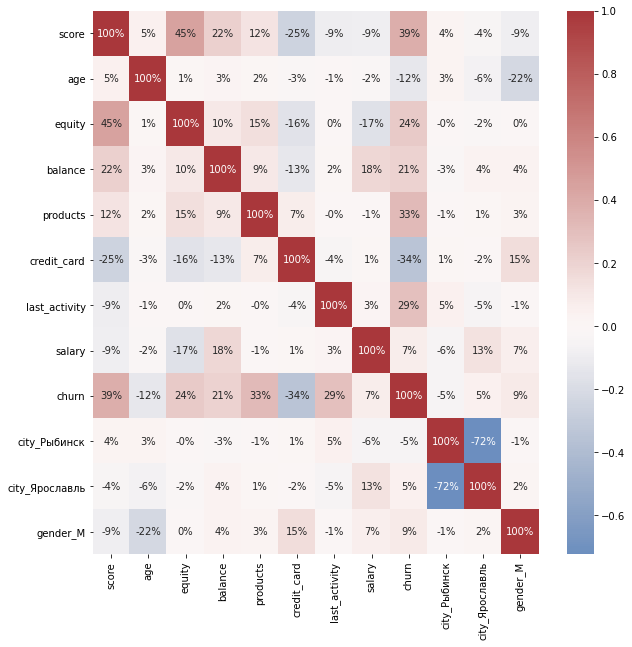

In [109]:
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.drop(columns = ['userid'],axis = 1).corr(),
            annot = True,
            fmt =".0%",
            cmap = "vlag",
            center = 0)

<AxesSubplot:>

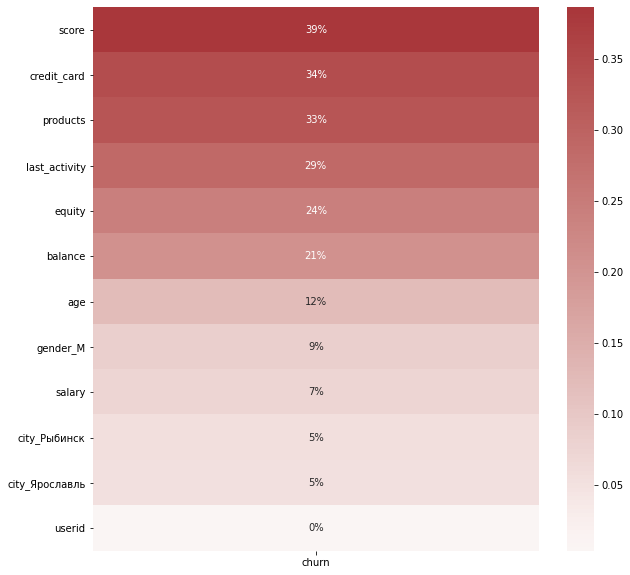

In [118]:
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(np.abs(df.corr().loc[:,['churn']]).sort_values(by = 'churn', ascending = False)[1:],
            annot = True,
            fmt =".0%",
            cmap = "vlag",
            center = 0)

interval columns not set, guessing: ['userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'city_Рыбинск', 'city_Ярославль', 'gender_М']


<AxesSubplot:>

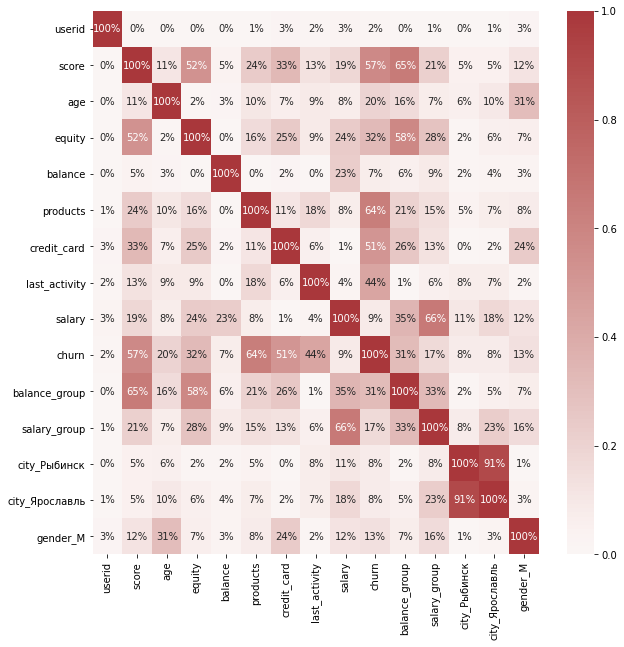

In [40]:
phik_overview = df.phik_matrix()
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(phik_overview,
            annot = True,
            fmt =".0%",
            cmap = "vlag",
            center = 0)

In [41]:
phik_overview['churn'].sort_values(ascending = False)

churn             1.000000
products          0.640059
score             0.574123
credit_card       0.509639
last_activity     0.435892
equity            0.324927
balance_group     0.314327
age               0.200756
salary_group      0.167563
gender_М          0.134220
salary            0.092174
city_Рыбинск      0.083373
city_Ярославль    0.079755
balance           0.070478
userid            0.017311
Name: churn, dtype: float64

### Выводы по EDA


- Клиенты имеющие низкий балл кредитного скоринга (до 630) практически не уходят
- Зависимость оттока от города практически отсутствует.
- Зависимость оттока от пола практически отсутствует.
- Зависимость оттока от возраста не обнаружена
- Клиенты с оценкой собственности "0" наименее сколнны к оттоку.
- Наблюдаем `резкий рост оттока с ростом суммы на счету`
- Основная часть клиентов имеет 1 продукт банка, 2 и 3 намного меньше.
- Среди клиентов имеющих 1 продукт - 12% отточных, 2 продукта 0%, `3 и 4 продукта 100%`
- Большинство наших клиентов имеют кредитную карту, однако, среди тех, `кто не имеет - 42% отточных`.
- Активных и неактивных пользователей по 50%, однако `среди активных 24% отточных`
- `С ростом зарплаты увеличивается и отточность клиентов`.
- Исходя из матрицы корреляции, наибольшее влияние на отток оказывают параметры `score, credit_card, products,last_activity, equity, balance`

## ML

### Создание модели

In [42]:
df.columns

Index(['userid', 'score', 'age', 'equity', 'balance', 'products',
       'credit_card', 'last_activity', 'salary', 'churn', 'balance_group',
       'salary_group', 'city_Рыбинск', 'city_Ярославль', 'gender_М'],
      dtype='object')

In [43]:
# удалим вспомогательные столбцы
df = df.drop(columns = ['balance_group','salary_group'])

In [44]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = ['score', 'age', 'equity', 'balance', 'products',
       'credit_card', 'last_activity', 'salary', 'city_Рыбинск', 'city_Ярославль', 'gender_М']
y = ['churn']

In [45]:
# зададим параметры модели
params = {'verbose' : 100,
          'random_seed' : 42,
          'learning_rate' : 0.04}

In [46]:
# создаём модель
model = CatBoostClassifier(**params)

In [47]:
# разделим на обучающую, тестовую и валидационную выборки
train, test = train_test_split(df, train_size=0.6, random_state = 42, stratify=df['churn'])
val, test = train_test_split(test, train_size=0.5, random_state = 42, stratify=test['churn'])

In [48]:
# обучим модель
model.fit(train[X], train[y], eval_set = (val[X],val[y]))

0:	learn: 0.5919222	test: 0.5912726	best: 0.5912726 (0)	total: 49ms	remaining: 49s
100:	learn: 0.0317843	test: 0.0375601	best: 0.0375601 (100)	total: 237ms	remaining: 2.11s
200:	learn: 0.0208515	test: 0.0314361	best: 0.0314090 (198)	total: 420ms	remaining: 1.67s
300:	learn: 0.0145122	test: 0.0286216	best: 0.0286216 (300)	total: 615ms	remaining: 1.43s
400:	learn: 0.0109394	test: 0.0274223	best: 0.0274223 (400)	total: 801ms	remaining: 1.2s
500:	learn: 0.0085437	test: 0.0269147	best: 0.0268495 (485)	total: 1.01s	remaining: 1.01s
600:	learn: 0.0068880	test: 0.0267502	best: 0.0266412 (591)	total: 1.21s	remaining: 805ms
700:	learn: 0.0057009	test: 0.0264638	best: 0.0263200 (644)	total: 1.4s	remaining: 598ms
800:	learn: 0.0047899	test: 0.0263589	best: 0.0263053 (772)	total: 1.58s	remaining: 393ms
900:	learn: 0.0040864	test: 0.0262505	best: 0.0262233 (836)	total: 1.76s	remaining: 194ms
999:	learn: 0.0035863	test: 0.0264712	best: 0.0262233 (836)	total: 1.95s	remaining: 0us

bestTest = 0.0262233

In [49]:
# получим предсказания - категории и скоры
test['score_cat'] = model.predict_proba(test[X])[:,1]
test['cat_pred'] = model.predict(test[X])
test.head()

userid  score  age  equity    balance  products  credit_card  \
6417  219316    505   33       2  792964.86         2            1   
1798  141527    653   50       6  234871.58         1            1   
2977   99769    809   47       2  564040.16         1            0   
2258  159643    604   39       3   17696.78         1            1   
7973   21186    375   61       0       0.00         1            1   

      last_activity     salary  churn  city_Рыбинск  city_Ярославль  gender_М  \
6417              1   27293.64  False             1               0         1   
1798              0    9210.80  False             1               0         0   
2977              0   68177.64  False             0               1         0   
2258              0   18327.47  False             0               1         0   
7973              1  148289.16  False             0               0         0   

      score_cat cat_pred  
6417   0.000113    False  
1798   0.000016    False  
2977   0.006199    False  
2258   0.000006    False  
7973   0.000003    False

In [50]:
# выведем roc_auc_score
print('ROC_AUC: {:.2f}'.format(roc_auc_score(test[y], test['score_cat'])))

ROC_AUC: 1.00


### Интерпретация модели

In [51]:
# получим важность фичей
model.get_feature_importance(prettified = True)

Feature Id  Importances
0    last_activity    26.733093
1            score    25.691216
2      credit_card     9.312008
3              age     8.612497
4         products     7.475419
5     city_Рыбинск     6.522939
6         gender_М     5.781320
7           salary     4.956233
8          balance     2.964955
9           equity     1.210426
10  city_Ярославль     0.739895

In [52]:
pd.DataFrame(phik_overview['churn'].sort_values(ascending = False))

churn
churn           1.000000
products        0.640059
score           0.574123
credit_card     0.509639
last_activity   0.435892
equity          0.324927
balance_group   0.314327
age             0.200756
salary_group    0.167563
gender_М        0.134220
salary          0.092174
city_Рыбинск    0.083373
city_Ярославль  0.079755
balance         0.070478
userid          0.017311

### Shap

In [53]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

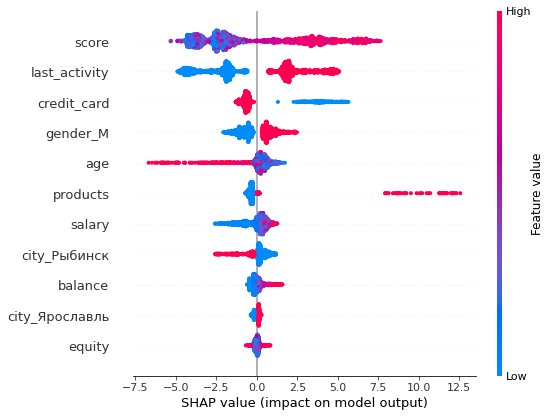

In [54]:
shap.summary_plot(shap_values, test[X])

In [55]:
features = model.get_feature_importance(prettified = True)['Feature Id'].values

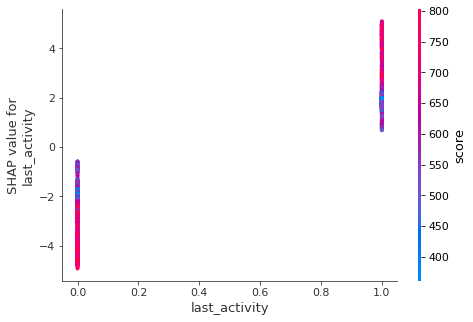

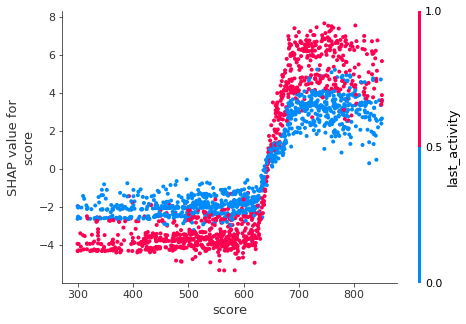

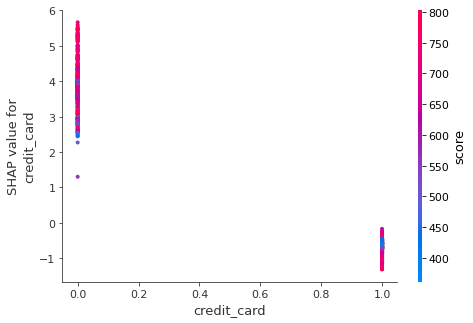

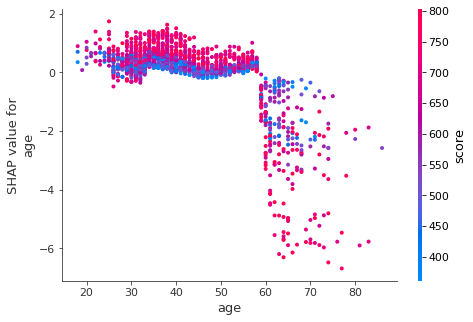

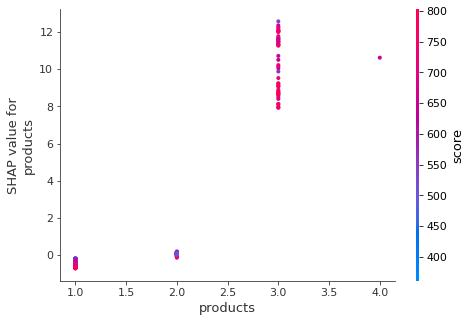

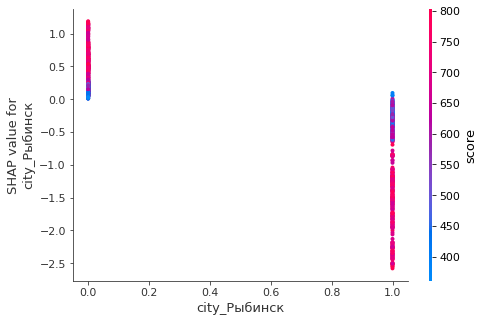

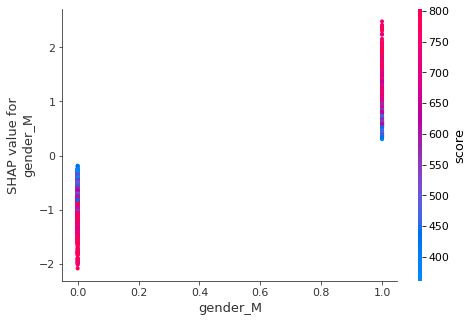

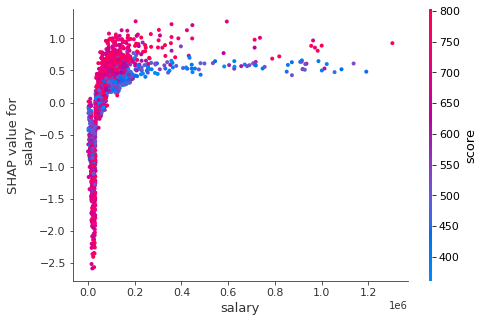

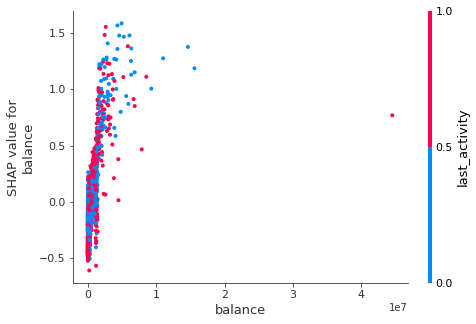

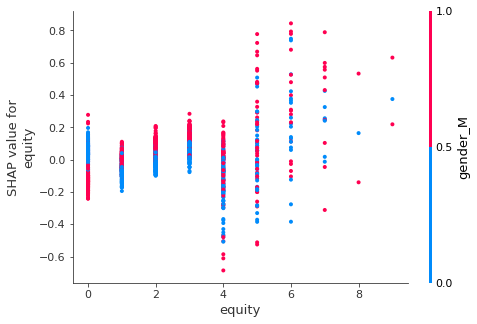

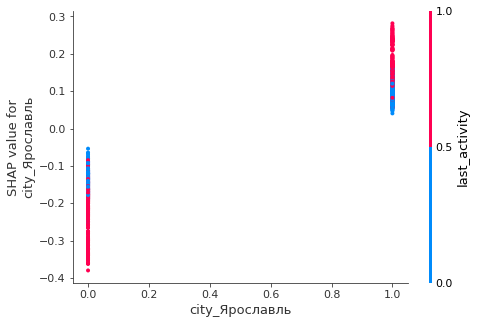

In [56]:
for feature in features:
    shap.dependence_plot(feature, shap_values, test[X])

### Выводы по ML

- мы построили модель ML CatBoostClassifier, предсказывающую отток по параметрам клиента, получили метрику ROC_AUC: 1.00
- анализ модели показал, что наибольшее влияние на отток имеют параметры: last_activity, score, credit_Card <br><br>
Модель повышает отточный score:
- активным пользователям
- тем у кого кредитный score больше 650
- тем, кто не имеет кредитку
- моложе 60 лет
- имеет три продукта
- мужчинам
- с зарплатой более 10000
- из Ярославля

## Построение портретов клиентов

### Анализ показателей

[Text(0.5, 1.0, 'Разброс групп по показателям')]

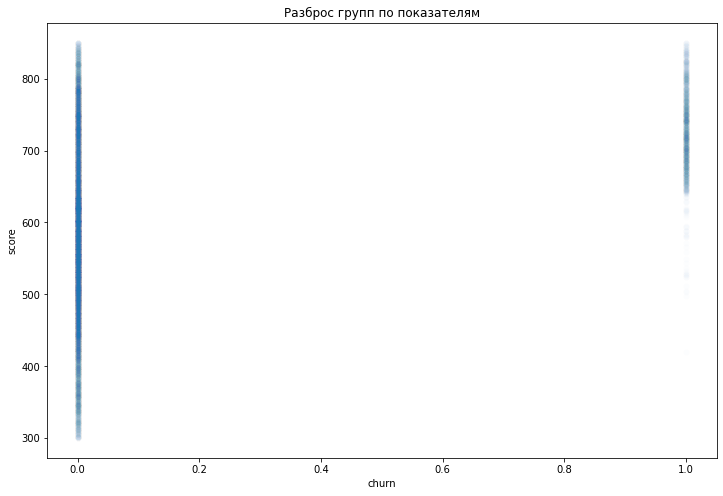

In [124]:
df['score_sc'] = df['score']/  df['score'].max()
mean_df = df.groupby('churn').mean()
median_df = df.groupby('churn').median()

plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'score', alpha = 0.01)
ax.set(title = 'Разброс групп по показателям')

<AxesSubplot:xlabel='churn_int', ylabel='score_sc'>

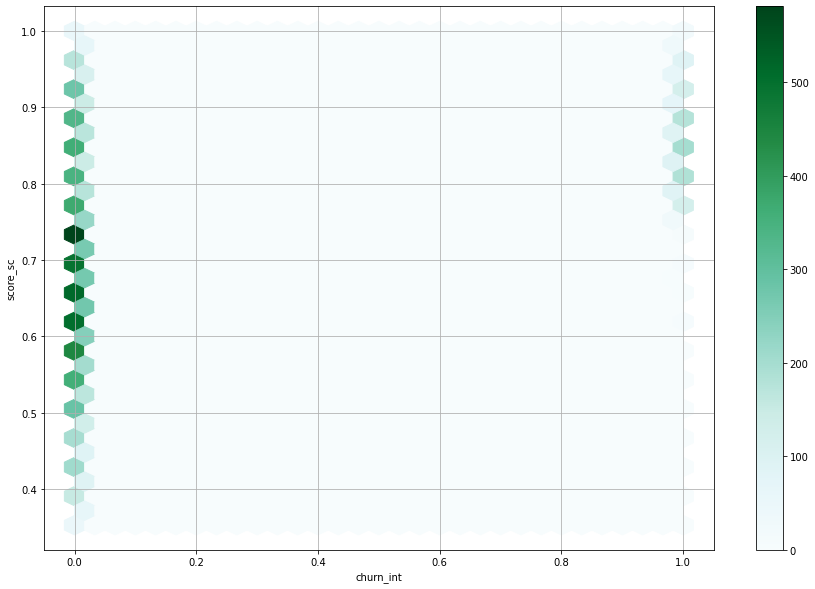

In [135]:
df['churn_int'] = df['churn'].astype('int')
df.plot(x = 'churn_int', y = 'score_sc', kind='hexbin', gridsize=30, figsize=(15, 10), sharex=False, grid=True)

(18.0, 50.0)

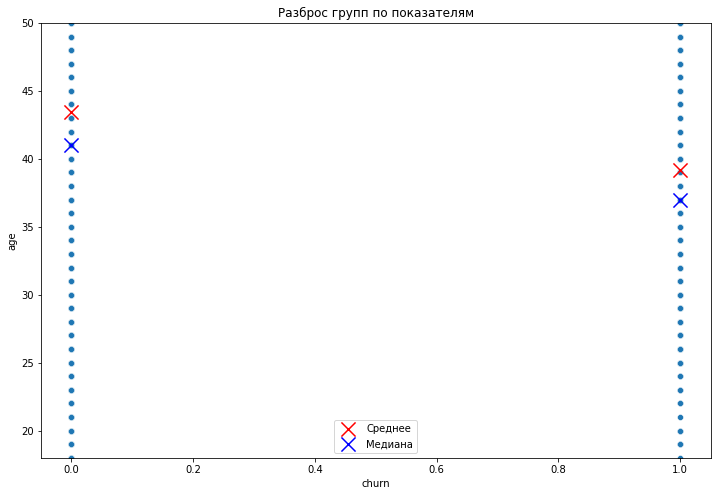

In [58]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'age')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.age, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.age, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()
plt.ylim([18,50])

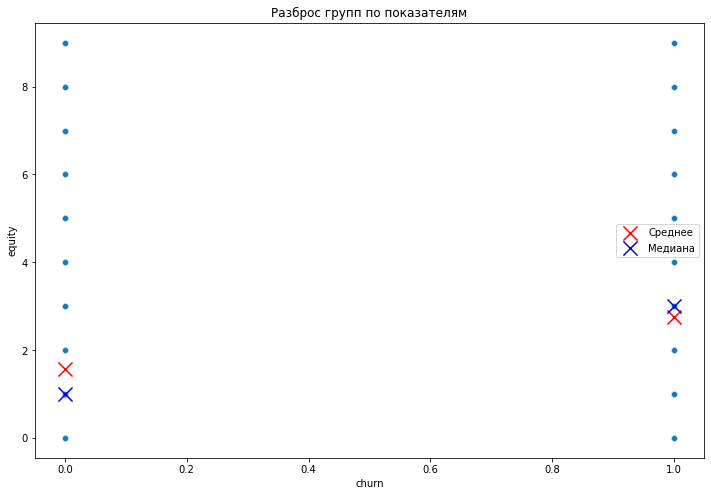

In [59]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'equity')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.equity, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.equity, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()

(0.0, 0.03)

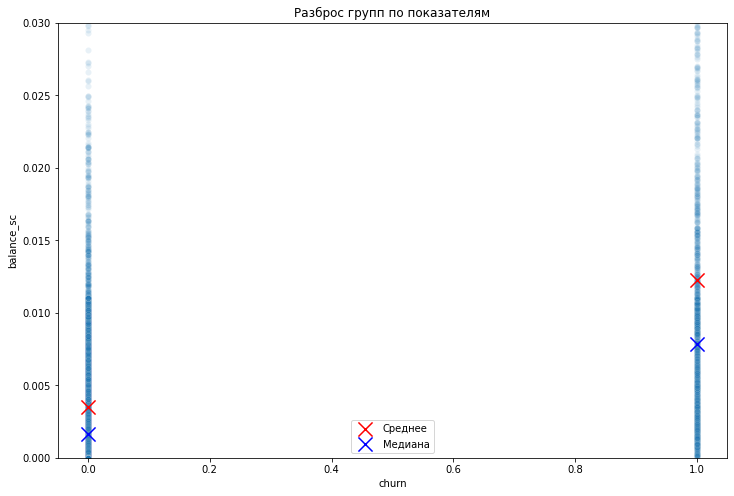

In [138]:
df['balance_sc'] = df['balance']/  df['balance'].max()
mean_df = df.groupby('churn').mean()
median_df = df.groupby('churn').median()

plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'balance_sc', alpha = 0.1)
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.balance_sc, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.balance_sc, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()
plt.ylim([0,0.03])

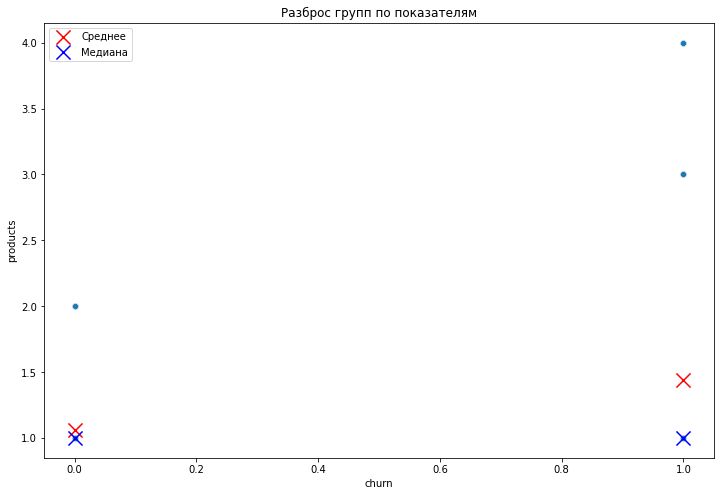

In [61]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'products')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.products, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.products, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()

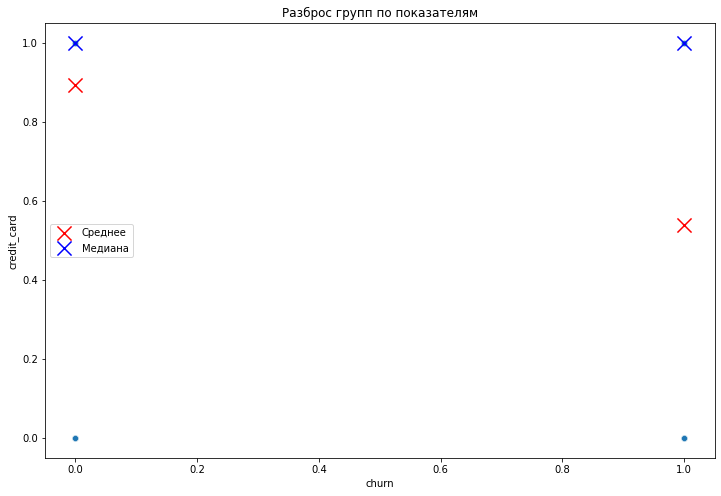

In [62]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'credit_card')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.credit_card, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.credit_card, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()

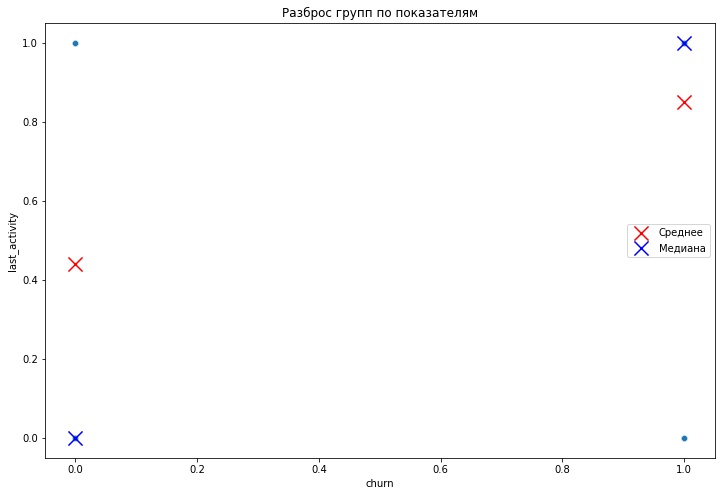

In [63]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'last_activity')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.last_activity, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.last_activity, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()

(0.0, 0.2)

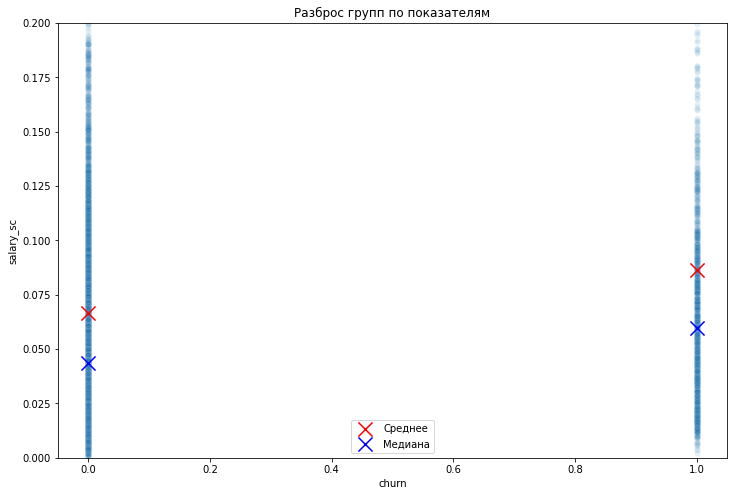

In [137]:
df['salary_sc'] = df['salary']/  df['salary'].max()

mean_df = df.groupby('churn').mean()
median_df = df.groupby('churn').median()

plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'salary_sc', alpha = 0.1)
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.salary_sc, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.salary_sc, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()
plt.ylim([0,0.2])

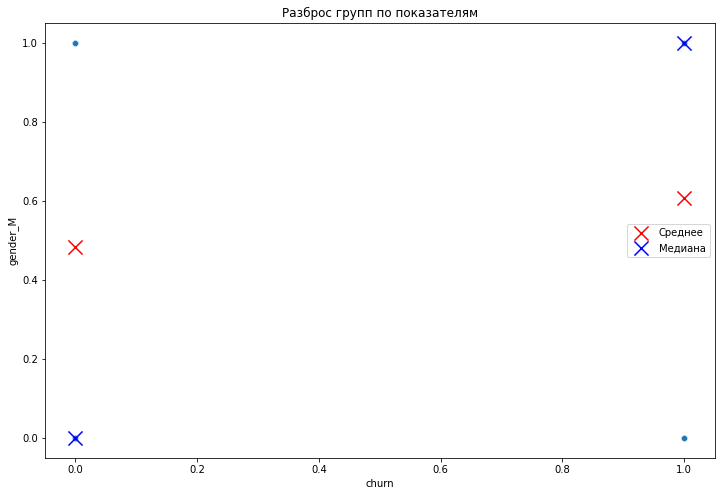

In [65]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = df, x = 'churn', y = 'gender_М')
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.gender_М, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.gender_М, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend()

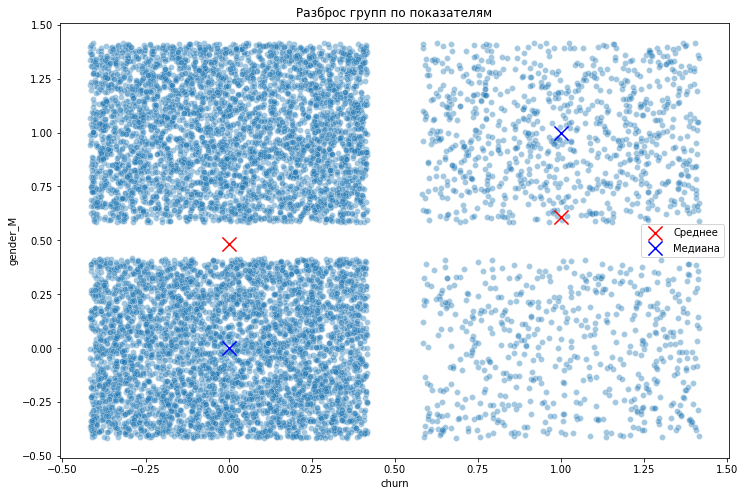

In [66]:
### КОД РЕВЬЮЕРА 
import numpy as np
# функция для добавления шума в числовые столбцы
def randomize(df:pd.DataFrame,k:float=1.2) -> pd.DataFrame:
    result = df.copy().astype(float, errors='ignore')
    num_cols = result.dtypes.apply(lambda x: np.issubdtype(x, np.number))
    num_arry = result.loc[:,num_cols]
    result.loc[:,num_cols] = num_arry - (np.random.random(num_arry.shape)-.5)/k
    return result


plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = randomize(df), x = 'churn', y = 'gender_М',alpha=.4)
ax.set(title = 'Разброс групп по показателям')

plt.scatter([0,1], mean_df.gender_М, s = 200, c = 'r', marker = 'x', label = 'Среднее')
plt.scatter([0,1], median_df.gender_М, s = 200, c = 'b', marker = 'x', label = 'Медиана')
plt.legend();

### Портреты пользователей

Изучив результаты EDA, матрицы корреляции и модели машинного обучения, мы пришли к выводам, что следующие параметры наиболее сильно коррелируют с отточностью пользователей:
- активность пользователя (24% активных пользователей отточны, матрица корреляции показала корреляцию 29%, также наша ML модель считае, что это самый важный показатель)
- Score - на графике явно видно, что до score ~ 600 нет отточных пользователей, это 2я по значимости фича в модели ML
- Наличие кредитной карты - 42% пользователей без кредитной карты - отточные, по матрице корреляция 34%, это 3я по значимости
  фича в модели ML
- Возраст - 4я фича модели ML
- Количество продуктов - пользователи 3 и 4 х продуктов 100% отточные
- Зарплата - графики показали явную зависимость отточности от зарплаты
- Баланс на счету - графики показали явную зависимость отточности от баланса
- Оценка собственности - графики показали явную зависимость отточности от оценки собственности

Остальные показатели мы считаем не важными для построения портретов пользователей и в итоге имеем следующие портреты:

Портрет "отточного" пользователя:
- активный пользователь
- score больше 600
- не имеет кредитной карты
- моложе 40 лет
- имеет 3-4 продукта
- зарплата более 90 000
- имеет на счету больше 1 млн.
- оценка собственности больше 1

Портрет "не отточного" пользователя:
- не активный пользователь
- score меньше 600
- имеет кредитную карту
- старше 40 лет
- имеет 1,2 продукта
- зарплата менее 90 000
- имеет на счету менее 1 млн.
- оценка 1

## Проверка гипотез

Для проверки наших гипотез мы будем использовать U-критерий Манна-Уитниэ.

Ограничения применимости критерия: 
- В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
- В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

Считаем, что наши данные удовлетворяют требованиям.

In [155]:
# проверим наши данные на нормальность. 
stat, p = scipy.stats.normaltest(df['churn']) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=3506.417, p-value=0.000
Отклонить гипотезу о нормальности


Наши данные распределены не нормально, поэтому t-тест использовать нельзя.

### Гипотеза о равенстве зарплат отточных и не отточных пользователей

Сформулируем гипотезы: <br>
__Н0:__ среднии зарплаты отточных и не отточных клиентов равны <br>
__Н1:__ среднии зарплаты отточных и не отточных клиентов __не__ равны


In [67]:
# формируем наши выборки одинкового размера
churn_users = df[df['churn'] == 1]['salary']
no_churn_users = df[df['churn'] == 0]['salary'].sample(1436)

In [153]:
alpha = .05

results = mannwhitneyu(
    churn_users, 
    no_churn_users)

print('p-значение:',results.pvalue) # ваш код: выведите на экран полученное p-значение)

if results.pvalue < alpha :# ваш код: сравните p-значение с заданным критическим уровнем стат. значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.45397334199836e-175
Отвергаем нулевую гипотезу


### Гипотеза о равенстве балансов отточных и не отточных пользователей

Сформулируем гипотезы: <br>
__Н0:__ среднии балансы отточных и не отточных клиентов равны <br>
__Н1:__ среднии балансы отточных и не отточных клиентов __не__ равны

In [69]:
# формируем наши выборки одинкового размера
churn_users = df[df['churn'] == 1]['balance']
no_churn_users = df[df['churn'] == 0]['balance'].sample(1436)

In [154]:
alpha = .05

results = mannwhitneyu(
    churn_users, 
    no_churn_users)

print('p-значение:',results.pvalue) # ваш код: выведите на экран полученное p-значение)

if results.pvalue < alpha :# ваш код: сравните p-значение с заданным критическим уровнем стат. значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.45397334199836e-175
Отвергаем нулевую гипотезу


### Выводы проверки статистических гипотез

- мы опровергли гипотезу о равенстве зарплат отточных и не отточных пользователей, то есть их зарплаты не равны
- мы опровергли гипотезу о равенстве балансов отточных и не отточных пользователей, то есть их балансы не равны

## Сегментация
1. Дипазоны параметров для отточных и действующих клиентов

In [71]:
segments = [
    ('Пользователи имеющие 1 продукт - кредитную карту', 'products == 1 and credit_card == 1'),
    ('Пользователи имеющие 1 продукт и  не имеют кредитку', 'products == 1 and credit_card == 0'),
    ('Пользователи имеющие 2 продукта', 'products == 2'),
    ('Пользователи имеющие 3 продукта','products == 3'),
    ('Пользователи имеющие 4 продукта','products == 4')
]

dfs_temp = []
for text, query in segments:
    result = df.query(query).agg({'churn':['mean','count']}).T
    result.index = [text]
    dfs_temp.append(result)
    
df_temp = pd.concat(dfs_temp)
df_temp['churn_suplus'] = df_temp['mean'] - df.churn.mean()
df_temp['idx'] = df_temp['count'] * df_temp['churn_suplus']
(df_temp.sort_values('idx', ascending = False)
                              .drop(['idx','mean'], axis = 1)
                              .style.format('{:.1%}', subset = ['churn_suplus'])
                              .format('{:,.0f}', subset = ['count']))

In [72]:
# посмотрим на пользователей 3х и 4х продуктов
df[df['products'] > 2].describe()

userid       score         age      equity       balance  \
count     314.000000  314.000000  314.000000  314.000000  3.140000e+02   
mean   149410.828025  723.853503   40.754777    2.942675  1.629925e+06   
std     72997.989553   79.810704    9.197881    1.937496  1.644421e+06   
min      5377.000000  503.000000   25.000000    0.000000  1.476510e+03   
25%     93371.750000  675.000000   34.000000    1.000000  6.146270e+05   
50%    158112.500000  733.500000   39.000000    3.000000  1.301961e+06   
75%    211797.750000  789.500000   47.000000    4.000000  1.944410e+06   
max    262274.000000  850.000000   66.000000    9.000000  1.644588e+07   

         products  credit_card  last_activity         salary  city_Рыбинск  \
count  314.000000   314.000000      314.00000     314.000000    314.000000   
mean     3.025478     0.968153        0.66879  125693.171083      0.194268   
std      0.157822     0.175873        0.47140  134453.866138      0.396267   
min      3.000000     0.000000        0.00000    3325.200000      0.000000   
25%      3.000000     1.000000        0.00000   56469.857500      0.000000   
50%      3.000000     1.000000        1.00000   94347.500000      0.000000   
75%      3.000000     1.000000        1.00000  141259.202500      0.000000   
max      4.000000     1.000000        1.00000  971504.440000      1.000000   

       city_Ярославль    gender_М    score_sc  balance_sc   salary_sc  
count      314.000000  314.000000  314.000000  314.000000  314.000000  
mean         0.684713    0.649682    0.851592    0.012896    0.091206  
std          0.465372    0.477831    0.093895    0.013011    0.097562  
min          0.000000    0.000000    0.591765    0.000012    0.002413  
25%          0.000000    0.000000    0.794118    0.004863    0.040976  
50%          1.000000    1.000000    0.862941    0.010301    0.068460  
75%          1.000000    1.000000    0.928824    0.015385    0.102501  
max          1.000000    1.000000    1.000000    0.130124    0.704943

/tmp/ipykernel_49/389798254.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<AxesSubplot:xlabel='products'>

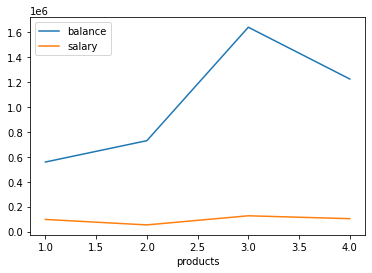

In [73]:
df.groupby('products')['balance', 'salary'].agg('mean').plot()

Пользователи 3х и 4х продуктов сильно склонны к оттоку, они имеют в среднем 1.6 млн на счету

## Выводы и рекомендации

### Выводы

Мы провели анализ клиентов банка "Метанпром". Выделили портрет клиентов склонных к оттоку, создали модель ML предсказывающую вероятность (скор) оттока клиента, проверили стат гипотезы и сформулировали рекомендации для отдела маркетинга.

В наших данных мы обнаружили в столбце balance 23% пропусков. Будем считать, что это нулевой баланс и заполним нулями
Так же в столбце products одна строка с 0, это скорее всего ошибка, удалим ее. Судя по данным, пропуски с балансом имеют пользователи с одним продуктом - кредитной картой, все они не отточные. Возможно это пользователи с заблокированными кредитками или исчерпавшими лимит. Дубликатов и проблемных выбросов не обнаружено (выдающиеся значения есть в возрасте, балансе, зарплате, но мы считаем это нормальным и не искажающим картину исследования)

- Клиенты имеющие низкий балл кредитного скоринга (до 630) практически не уходят
- Зависимость оттока от города практически отсутствует.
- Зависимость оттока от пола практически отсутствует.
- Зависимость оттока от возраста не обнаружена
- Клиенты с оценкой собственности "0" наименее сколнны к оттоку.
- Наблюдаем резкий рост оттока с ростом суммы на счету
- Основная часть клиентов имеет 1 продукт банка, 2 и 3 намного меньше. <br> 
Среди клиентов имеющих 1 продукт - 12% отточных, 2 продукта 0%, `3 и 4 продукта 100%`
- Большинство наших клиентов имеют кредитную карту, однако, среди тех, кто не имеет - 42% отточных. Те кто имеют `только` кредитную карту - не отточные.
- Активных и неактивных пользователей по 50%, однако среди активных 24% отточных.Большинство активных пользователей имеют один продукт - кредитную карту.
- С ростом зарплаты увеличивается и отточность клиентов.
- Исходя из матрицы корреляции, наибольшее влияние на отток оказывают параметры `score, credit_card, products,last_activity, equity, balance`



- мы построили модель ML CatBoostClassifier, предсказывающую отток по параметрам клиента, получили метрику ROC_AUC: 1.00
- анализ модели показал, что наибольшее влияние на отток имеют параметры: last_activity, score, credit_Card <br><br>
Модель повышает отточный score:
- активным пользователям
- тем у кого кредитный score больше 650
- тем, кто не имеет кредитку
- моложе 60 лет
- имеет три продукта
- мужчинам
- с зарплатой более 10000
- из Ярославля


Портрет `"отточного"` пользователя:
- активный пользователь
- score больше 600
- не имеет кредитной карты
- моложе 40 лет
- имеет 3-4 продукта
- зарплата более 90 000
- имеет на счету больше 1 млн.
- оценка собственности больше 1

Портрет `"не отточного"` пользователя:
- не активный пользователь
- score меньше 600
- имеет кредитную карту
- старше 40 лет
- имеет 1,2 продукта
- зарплата менее 90 000
- имеет на счету менее 1 млн.
- оценка 1
<br><br>
- мы опровергли гипотезу о равенстве зарплат отточных и не отточных пользователей, то есть их зарплаты не равны
- мы опровергли гипотезу о равенстве балансов отточных и не отточных пользователей, то есть их балансы не равны



### Рекомендации

- Для сегмента 1 "Пользователи имеющие 1 продукт и имеют кредитку" - в целом все хорошо, у них низкий отток
- Для сегмента 2 "Пользователи имеющие 1 продукт и не имеют кредитку" - предложить оформить кредитную карту, так мы их переведем в другой сегмент, где доля оттока меньше. Наличие кредитной карты понижает вероятность оттока.
- Для сегмента 3 "Пользователи имеющие 2 продукта" - в целом все хорошо, у них низкий отток
- Для сегментов 4 и 5 -  "Пользователи имеющие 3 и 4 продукта" предложить услуги для премиальных клиентов - депозиты, сейфовые ячейки, личные менеджеры. Исходя из анализа это и есть наша основная боль, мы теряем клиентов имеющих несколько продуктов. А эти пользователи имеют самые большие суммы на счету, средняя сумма 1.6 млн. Возможно они разочаровываются в нашем сервисе, предлагаю провести фокус группу и посмотреть на опыт пользователя. 

## Презентация

https://ranepa-my.sharepoint.com/:p:/g/personal/nekrasov-ev_ranepa_ru/EfV5E12EMcNDugxOeXNfRE8BZ-TBYUvpMVmR3tbSdA7rDw?e=YgXISX
